Title:

Name:

UW Email:

# Abstract

TODO


# Team members & contributions

TODO

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torchvision.datasets as datasets
from torchvision.models import ResNet18_Weights

from sklearn.cluster import KMeans

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

In [38]:
# TODO: create more datasets

UNLABELLED = -1

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 datasets
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_valid = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def generate_indices(dataset, pct_labelled):
    num_samples = int(0.1 * len(dataset))
    return torch.randperm(len(dataset))[:num_samples]

indices_10 = generate_indices(cifar_train, 0.1)

# Define datasets for fully supervised learning

full_dataset_10 = torch.utils.data.Subset(cifar_train, indices_10)
full_loader_10 = DataLoader(full_dataset_10, batch_size=128, shuffle=True, num_workers=2)

loader_valid = DataLoader(cifar_valid, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [39]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # initialize weights to make training easier (via transfer learning)
        self.model.fc = nn.Identity()
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        features = self.model(x)
        x = self.fc(features)
        return x, features

# Supervised learning

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

full_model_10 = Model()

full_model_10.train()
full_model_10.to(device)

optimizer = torch.optim.SGD(full_model_10.parameters(), lr=0.0001, momentum=0.9)
num_epochs = 5

losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm(full_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = full_model_10(images)

        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



  0%|          | 0/40 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 40/40 [00:15<00:00,  3.00it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


Epoch 1/10, Loss: 2.3538


100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


Epoch 2/10, Loss: 2.1860


100%|██████████| 40/40 [00:15<00:00,  2.53it/s]


Epoch 3/10, Loss: 1.8731


100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


Epoch 4/10, Loss: 1.5780


100%|██████████| 40/40 [00:15<00:00,  2.58it/s]

Epoch 5/10, Loss: 1.4918


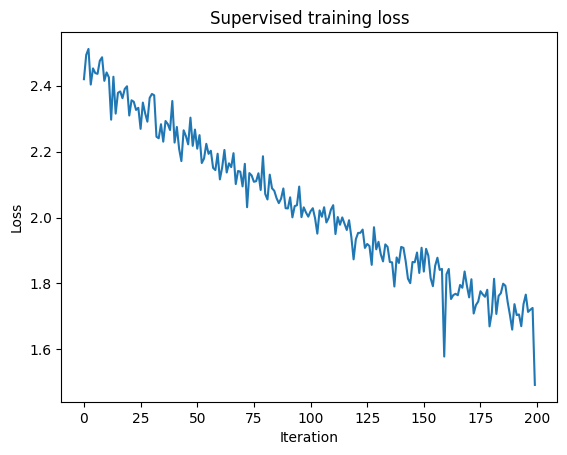

In [41]:
plt.plot(losses)
plt.title('Supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [42]:
# TODO: make this its own function maybe (e.g. evaluate_model)?

# Evaluate the model
full_model_10.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = full_model_10(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the supervised trained model: %d %%' % (100 * correct / total))


Accuracy of the supervised trained model: 49 %


In [43]:
# Compared to untrained model

untrained_model = Model()
untrained_model.eval()
untrained_model.to(device)

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = untrained_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of an untrained model : %d %%' % (100 * correct / total))


Accuracy of an untrained model : 10 %


# Semi-supervised learning

In [44]:
# Custom dataset for semi-supervised learning
class SemiSupervised(torch.utils.data.Dataset):
    def __init__(self, labeled_dataset, indices):
        self.labeled_dataset = labeled_dataset
        self.labeled_indices = indices

    def __getitem__(self, index):
        if index in self.labeled_indices:
            return self.labeled_dataset[index]
        else:
            img, label = self.labeled_dataset[index]
            return img, UNLABELLED

    def __len__(self):
        return len(self.labeled_dataset)

# Create semi-supervised datasets
semi_dataset_10 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_10
)

semi_loader_10 = DataLoader(semi_dataset_10, batch_size=128, shuffle=True, num_workers=2)

In [45]:
# non-parametric softmax operation by Wu et. al.
# axis 0: v, axis 1: i
def PIV(features, temp):
  upper = torch.exp(torch.matmul(features, features.T) / temp)
  denom = upper.sum(axis=1)
  return upper / denom

def weighted_knn(features, labels, k, temp):
  # Calculate the distances between each pair of points
    mask = torch.where(labels == UNLABELLED)
    unlabelled_features = (features[mask])
    labelled_features = features[labels != UNLABELLED]
    only_labels = labels[labels != UNLABELLED]

    distances = torch.cdist(unlabelled_features, labelled_features, p=2)

    # Find the k nearest neighbors for each point in x
    _, indices = torch.topk(distances, k=min(k, len(only_labels)), largest=False)

    piv = PIV(features, temp)

    weights = torch.zeros((len(mask[0]), 10))
    weights = weights.to(device)

    for i, idxs in enumerate(indices):
      v = mask[0][i]
      for j in idxs:
        weights[i][only_labels[j]] += piv[v, j]

    probs = weights / weights.sum(axis=1)[:, None]

    pseudo_confidence, pseudo_labels = probs.max(axis=1)

    pseudo_labels = pseudo_labels.to(device)
    pseudo_confidence = pseudo_confidence.to(device)

    new_labels = labels.clone()
    new_labels[mask] = pseudo_labels

    confidence = torch.ones_like(labels, dtype=pseudo_confidence.dtype)
    confidence[mask] = pseudo_confidence

    return new_labels, confidence

# TODO: add LLP
def LLP(features, labels, temp):
  pass


In [46]:
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(KMeansClusteringLoss, self).__init__()

    def forward(self, features, centroids):
        n = features.shape[0]
        d = features.shape[1]
        k = centroids.shape[0]

        z = features.reshape(n, 1, d)
        z = z.repeat(1, k, 1)

        mu = centroids.reshape(1, k, d)
        mu = mu.repeat(n, 1, 1)

        dist = (z - mu).norm(2, dim=2).reshape((n, k))
        loss = (dist.min(dim=1)[0] ** 2)

        return loss

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_10 = Model()

semi_model_10.train()
semi_model_10.to(device)

optimizer = torch.optim.SGD(semi_model_10.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.01 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 10
TEMP = 25

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_10(images)

        # pseudo-labelling
        pseudo_labels, confidence = weighted_knn(features, labels, K, TEMP)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        # print('CLUSTER LOSS: ', cluster_loss.mean().item())

        ce_loss = criterion(outputs, pseudo_labels)

        # print('CE LOSS: ', ce_loss.mean().item())

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



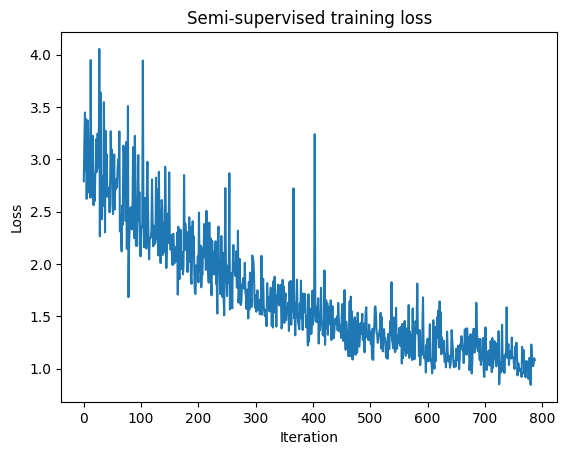

In [48]:
plt.plot(losses)
plt.title('Semi-supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [49]:
# Evaluate the model
semi_model_10.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = semi_model_10(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the semi-supervised trained model: %d %%' % (100 * correct / total))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the semi-supervised trained model: 14 %
